In [1]:
from dlc_practical_prologue import *
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F


train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(
    1000)


In [2]:
train_input_norm = (train_input - torch.min(train_input)) / (torch.max(train_input))
test_input_norm = (test_input - torch.min(train_input)) / (torch.max(train_input))

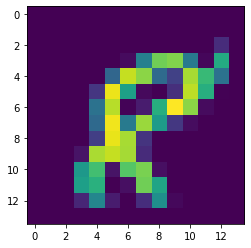

In [3]:
plt.imshow(train_input_norm[550][0])

In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
class Net2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Flatten()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, 10)
        self.fc5 = nn.Linear(10, 1)
        self.fc6 = nn.Linear(2, 1)
        
        self.logsoft = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        # INPUT IS A (2, 14, 14) TENSOR, OUTPUT IS (1)
        x = self.fc0(x)
        # (2, 196)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        output1 = self.logsoft(x)
        #x = F.relu(self.fc5(torch.exp(x)))
        x = F.relu(self.fc5(x))
        x = torch.flatten(x, 0)
        output2 = self.fc6(x)
        #print(output2)
        return output1, output2


In [106]:
class Net_convo(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, 1, groups=2)
        self.norm = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, groups=2)
        self.lin1 = nn.Linear(3200, 10)
        self.lin2 = nn.Linear(10, 1)
        self.lin3 = nn.Linear(2, 1)
        
        self.logsoft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # (25, 2, 14, 14)
        # We use batch normalization for covariate shift
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 1)
        x = self.norm(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 1)
        x = x.view(25, 2, -1)
        x = torch.flatten(x, 2)
        # (25, 2, 3200)
        x = F.relu(self.lin1(x))
        # (25, 2, 10)
        output1 = self.logsoft(x)
        # (25, 2, 10)
        x = F.relu(self.lin2(x))
        print(x.size())
        # (25, 2, 1)
        x = torch.flatten(x, 1)
        # (25, 2)
        output2 = F.relu(self.lin3(x))
        # (25, 1)
        return output1, output2
    
get_n_params(Net_convo())

41688

## Batches of (2, 14, 14)

In [78]:
model = Net2()

criterion1 = nn.NLLLoss()
criterion2 = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.75)
time0 = time()
epochs = 25

for e in range(epochs):
    running_loss = 0
    for i in range(len(train_input_norm)):


        optimizer.zero_grad()
        #optimizer_aux.zero_grad()
        #print(torch.flatten(train_input_flat.narrow(0, b, mini_batch_size), 1, 2).size())

        output1, output2 = model(train_input_norm[i])
        loss1 = criterion1(output1, train_classes[i])
        loss2 = criterion2(output2, train_target[i].reshape(1).to(torch.float32))
        
        w2 = 0.3

        loss = loss1 + loss2 * w2
        loss.backward()
        optimizer.step()
        break


        running_loss += loss1.item() + loss2.item() * w2
    break
    print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(train_input)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    

torch.Size([2, 10]) output1
torch.Size([1]) output2


## Batches of (b, 2, 14, 14)

In [107]:

# WITH BATCHES


model = Net_convo()

criterion1 = nn.NLLLoss()
criterion2 = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.6)
time0 = time()
epochs = 25

mini_batch_size = 25

for e in range(epochs):
    running_loss = 0
    for b in range(0, train_input.size(0), mini_batch_size):


        optimizer.zero_grad()
        output1, output2 = model(train_input.narrow(0, b, mini_batch_size))
        
        loss1 = criterion1(output1.view(-1, 10), train_classes.narrow(0, b, mini_batch_size).view(-1))
        loss2 = criterion2(output2.view(-1), train_target.narrow(0, b, mini_batch_size).to(torch.float32))

        w2 = 0.3

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()



        running_loss += loss1.item() + loss2.item() * w2

    print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(train_input)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    

torch.Size([25, 2, 1])
torch.Size([25, 2, 1])
torch.Size([25, 2, 1])


KeyboardInterrupt: 

In [103]:
def compute_err_digit_recog(model, test_input, test_classes, batches = False): # CHANGER LES NOMS SVP

    correct_count_digit, all_count_digit = 0, 0
    correct_count_equal, all_count_equal = 0, 0
    
    if not batches:
    
    
        for img, label, target, i in zip(test_input, test_classes, 
                                                test_target, range(len(test_classes))):   
            with torch.no_grad():
                log_probs_digits, probs_equality = model(img)


            probs = torch.exp(log_probs_digits)
            _, preds = torch.max(probs,dim=1)
            true_labels = label

            for predicted, groundtruth in zip(preds, true_labels):
                if(predicted == groundtruth):
                    correct_count_digit += 1
                #print(predicted, groundtruth)
                all_count_digit += 1



            if((torch.sigmoid(probs_equality) >= 0.5 and target == 1) or 
                       (torch.sigmoid(probs_equality) < 0.5 and target == 0)):
                correct_count_equal += 1
            all_count_equal +=1
            
            
    else:

        for i in range(0, len(train_input_norm), mini_batch_size):
        
            with torch.no_grad():
                log_probs_digits, probs_equality = model(test_input.narrow(0, b, mini_batch_size))
            
            probs = torch.exp(log_probs_digits)
            _, preds = torch.max(probs,dim=2)
            true_labels = test_classes.narrow(0, b, mini_batch_size)
            targets = test_target.narrow(0, b, mini_batch_size)
            
            
            
            for predicted, groundtruth in zip(preds, true_labels):
                if(predicted[0] == groundtruth[0]):
                    correct_count_digit += 1
                if(predicted[1] == groundtruth[1]):
                    correct_count_digit += 1
                #print(predicted, groundtruth)
                all_count_digit += 2
               
            for prob_equality, target in zip(probs_equality.view(-1), targets):
                if((torch.sigmoid(prob_equality) >= 0.5 and target == 1) or 
                           (torch.sigmoid(prob_equality) < 0.5 and target == 0)):
                    correct_count_equal += 1
                all_count_equal +=1
            
            
        
    print("Number Of Images Tested =", all_count_digit)
    print("\nModel Accuracy =", (correct_count_digit/all_count_digit), '\n\n')
    print("Number Of Inequalities tested =", all_count_equal)
    print("\nModel Accuracy =", (correct_count_equal/all_count_equal))
    
compute_err_digit_recog(model, test_input_norm, test_classes, batches = True)

Number Of Images Tested = 2000

Model Accuracy = 0.5745 


Number Of Inequalities tested = 1000

Model Accuracy = 0.64
